<a href="https://colab.research.google.com/github/devtico/winequality/blob/master/vinho_vermelho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predição da qualidade do vinho </h1>

In [ ]:
%%capture
! pip install dtreeviz # pacote para visualizar o resultado
import pandas as pd
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import dtreeviz.trees as trv

##Baixando os bancos de dados

In [ ]:
tinto = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
branco = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

Normalizando os valores de densidade:

In [ ]:
def zscore(x):
  return (x - np.mean(x)) / np.std(x)

In [ ]:
tinto.density = zscore(tinto.density)

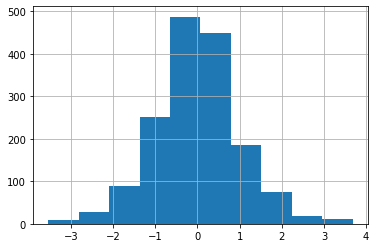

In [ ]:
tinto.density.hist()

Quantas valores de qualidade diferentes existem?

In [ ]:
tinto.quality.value_counts(sort=False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

## Preparação dos dados para o modelo
20% para teste 80% para treino

In [ ]:
tinto_X_train, tinto_X_test, tinto_Y_train, tinto_Y_test = train_test_split(
    tinto.iloc[:, 0:11],
    tinto.quality,
    test_size=0.2,
    random_state=1234,
    stratify=tinto.quality)

## Árvore de decisão

In [ ]:
modelo_tinto = DecisionTreeClassifier(min_samples_leaf=50,
                                      min_impurity_decrease=0.01,
                                      class_weight='balanced',
                                      random_state=1234)

In [ ]:
modelo_tinto.fit(tinto_X_train, tinto_Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


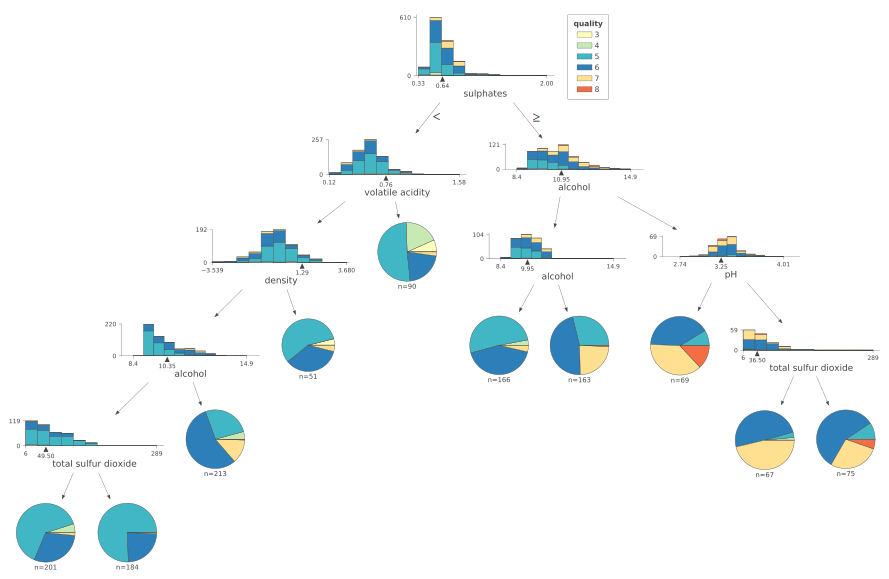

In [ ]:
viz = trv.dtreeviz(modelo_tinto,
                   tinto_X_train,
                   tinto_Y_train,
                   target_name='quality',
                   feature_names = tinto.iloc[:,0:11].columns,
                   class_names=['3', '4', '5', '6', '7', '8']);
viz

## Avaliando o modelo
percentual de acertos:

In [ ]:
accuracy_score(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

0.33125

Matriz de confusão

In [ ]:
confusion_matrix(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

array([[ 1,  0,  1,  0,  0,  0],
       [ 2,  4,  2,  3,  0,  0],
       [22, 23, 56, 19, 10,  6],
       [10, 17, 28, 31, 23, 19],
       [ 0,  2,  2,  9, 13, 14],
       [ 0,  0,  1,  0,  1,  1]])

Nova métrica: diferença de qualidade

In [ ]:
def abs_dif(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred))

In [ ]:
abs_dif(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

1.01875

##Otimização do modelo

In [ ]:
parametros = {'min_samples_leaf': [10, 20 ,30, 40, 50, 60, 70, 80, 90, 100],
              'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
              'class_weight': ['balanced', None],
              'splitter':['best', 'random'],
              'max_depth': [3, 4, 5, None],
              'criterion': ['gini', 'entropy']}
tinto_opt = GridSearchCV(modelo_tinto, parametros,
                         cv=5,
                         iid=False,
                         scoring=make_scorer(abs_dif, greater_is_better=False))

In [ ]:
tinto_opt.fit(tinto_X_train, tinto_Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.01,
                                              min_impurity_split=None,
                                              min_samples_leaf=50,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1234,
                                              splitter='best'),
             iid=...
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         

In [ ]:
tinto_opt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

Árvore otimizada

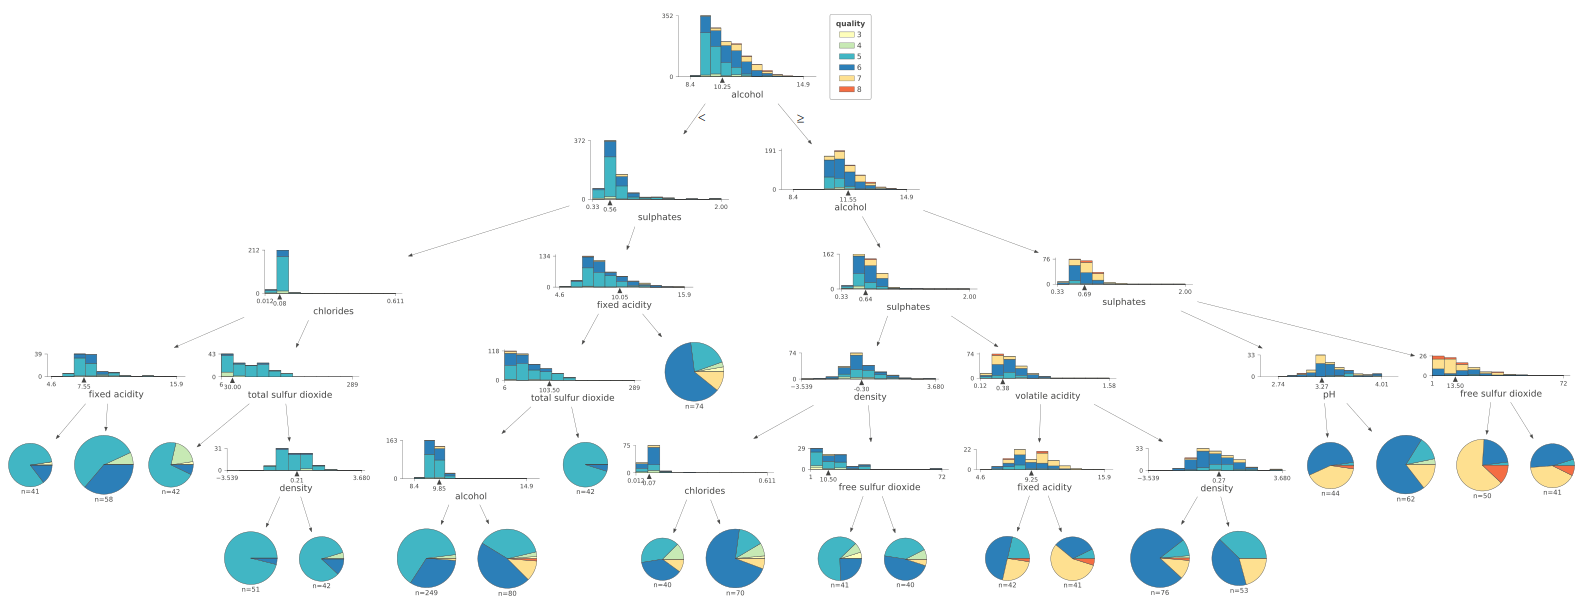

In [ ]:
viz = trv.dtreeviz(tinto_opt.best_estimator_,
                   tinto_X_train,
                   tinto_Y_train,
                   target_name='quality',
                   feature_names = tinto.iloc[:,0:11].columns,
                   class_names=['3', '4', '5', '6', '7', '8']);
viz

##Avaliando modelo otimizado

percentual de acerto

In [ ]:
accuracy_score(tinto_Y_test, tinto_opt.predict(tinto_X_test))

0.553125

Diferença absoluta

In [ ]:
abs_dif(tinto_Y_test, tinto_opt.predict(tinto_X_test))

0.484375

Matriz confusão

In [ ]:
pd.DataFrame(
    confusion_matrix(tinto_Y_test, tinto_opt.predict(tinto_X_test)),
                 index=pd.MultiIndex.from_product([["True"],
                                                   ["3", "4", "5", "6", "7", "8"]]),
                 columns=pd.MultiIndex.from_product([["Predicted"],
                                                     ["3", "4", "5", "6", "7", "8"]]))

Predicted                  
               3  4   5   6   7  8
True 3         0  0   1   1   0  0
     4         0  0   9   2   0  0
     5         0  0  88  48   0  0
     6         0  0  46  78   4  0
     7         0  0   5  24  11  0
     8         0  0   0   2   1  0